## Treniranje jezičkog modela
U ovoj svesci rekonstruišemo ceo postupak pravljenja *CWE*-a, i koristimo tako dobijene reprezentacije sa UPOS klasifikatorom. Koraci za ovaj postupak su:
- pravimo rečnik za srpsku latinicu na osnovu tekstova na srpskom jeziku uzetih sa Vikipedije
- pravimo ugnježdavače(embeddere) unapred i unazad na osnovu UD_SERBIAN skupa i preporučenih parametara od strane Flair tima
- pravimo model za etiketiranje koji se oslanja na dobijena ugnježdavanja
    - optimizujemo model na prostoru hiperparametra koristeći validacioni skup validacionih podataka
    - treniramo model još jednom sa najboljim parametrima
    - evaluiramo tako dobijeni model

In [2]:
import flair.datasets
from flair.data import Sentence, Dictionary
from flair.datasets import ColumnCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger, LanguageModel
from flair.trainers import ModelTrainer, LanguageModelTrainer, TextCorpus
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import collections
import glob
import pickle
import json

### Generisanje rečnika za srpsku latinicu
- tekstovi na osnovu kojih smo generisali rečnik se mogu naći u direktorijumu `"corpus/corpus3"`

In [3]:
char_dictionary: Dictionary = Dictionary()
counter = collections.Counter()

In [4]:
files = glob.glob('corpus/corpus3/**/*', recursive=True)
files.remove('corpus/corpus3\\train')
print(files)

['corpus/corpus3\\test.txt', 'corpus/corpus3\\valid.txt', 'corpus/corpus3\\train\\train_split_1', 'corpus/corpus3\\train\\train_split_2']


In [5]:
# Broj procesuiranih linija
processed = 0

for file in files:

    with open(file, 'r', encoding='utf-8') as f:

        tokens = 0

        for line in f:
            processed += 1
            chars = list(line)
            tokens += len(chars)

            # Dodaj karaktere u rečnik
            counter.update(chars)


In [6]:
counter.keys()

dict_keys(['1', '9', '8', '4', 'K', 'a', 'o', ' ', 'i', 'b', 'č', 'n', ',', 'l', 'c', 'e', 'E', 'm', 'u', 'G', 'd', 'š', 't', 'j', 'N', 'r', 'g', 'p', '-', 's', 'k', '.', 'T', 'z', 'S', 'ž', 'h', 'đ', 'v', '(', ')', 'ć', 'P', 'V', 'B', 'D', 'O', ':', '–', 'f', '\n', '2', '0', 'I', 'M', 'A', 'U', 'L', 'Č', '’', '„', '!', '“', 'R', ';', 'J', 'Ž', 'Š', '3', 'Z', 'Ć', '5', '6', '7', '?', '/', 'H', '*', 'w', 'y', 'X', 'Y', 'ñ', '\xad', 'F', '=', 'â', 'C', '—', '[', ']', '_', "'", '^', '|', '&', '>', '<', '{', '}', '#', '+', '%', '”', '\\', '`', '~', 'Đ', '"'])

In [7]:
# Nabrojavanje elemenata sortirani po frekvenciji u korpusu i sumarizacija njihovih pojavljivanja
total_count = 0
for letter, count in counter.most_common():
    total_count += count

In [8]:
print("Total number of characters:",total_count)
print("Total number of processed lines:", processed)

Total number of characters: 67079
Total number of processed lines: 93


In [9]:
# Pomoćne strukture za generisanje rečnika
latin = set("abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽ")
numbers = set("0123456789")
punct = set(".?!,:;\"\'\/()[]{}_+-*^%#<>|&`~")

In [10]:
# Provere validnosti podskupova
latin.issubset(set(counter.keys()))

True

In [11]:
numbers.issubset(set(counter.keys()))

True

In [12]:
punct.issubset(set(counter.keys()))

True

### Dodavanje slova u rečnik i ispis njihovih informacija

In [13]:
summ = 0
idx = 0
for letter, count in counter.most_common():
    summ += count
    percentile = (summ / total_count)

    char_dictionary.add_item(letter)
    idx += 1
    print('%d\t%s\t%7d\t%7d\t%f' % (idx, letter, count, summ, percentile))

1	 	  11740	  11740	0.175018
2	a	   5880	  17620	0.262675
3	o	   5229	  22849	0.340628
4	e	   4862	  27711	0.413110
5	i	   4649	  32360	0.482416
6	n	   3353	  35713	0.532402
7	r	   2515	  38228	0.569895
8	t	   2454	  40682	0.606479
9	s	   2400	  43082	0.642258
10	j	   2223	  45305	0.675398
11	u	   2144	  47449	0.707360
12	d	   1967	  49416	0.736684
13	l	   1810	  51226	0.763667
14	m	   1774	  53000	0.790113
15	k	   1762	  54762	0.816381
16	v	   1736	  56498	0.842261
17	p	   1390	  57888	0.862982
18	g	    940	  58828	0.876996
19	,	    831	  59659	0.889384
20	b	    793	  60452	0.901206
21	z	    786	  61238	0.912924
22	.	    603	  61841	0.921913
23	č	    509	  62350	0.929501
24	š	    480	  62830	0.936657
25	c	    364	  63194	0.942083
26	ž	    302	  63496	0.946585
27	h	    272	  63768	0.950640
28	ć	    244	  64012	0.954278
29	-	    133	  64145	0.956261
30	1	    122	  64267	0.958079
31	S	    122	  64389	0.959898
32	f	    118	  64507	0.961657
33	A	    108	  64615	0.963267
34	đ	    101	  6471

In [14]:
with open('resources/char_mappings/latin_dict', 'wb') as f:
    mappings = {
        'idx2item': char_dictionary.idx2item,
        'item2idx': char_dictionary.item2idx
    }
    pickle.dump(mappings, f)

### Treniranje ugnježdavanja
#### Treniranje ugnježdavanja unapred

In [15]:
# Na ovaj način menjamo tip ugnježdavanja (unapred ili unazad)
is_forward_lm = True
dictionary: Dictionary = Dictionary.load_from_file('resources/char_mappings/latin_dict')

# Koristimo korpus uzet sa vikipedije za treniranje ugnježdavanja
corpus_fw = TextCorpus('corpus/corpus3',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# U pozadini LanguageModel-a je rekurzivna neuronska mreza iz PyTorch bibloteke, konkretno LSTM ili GRU
language_model_fw = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer_fw = LanguageModelTrainer(language_model_fw, corpus_fw)

trainer_fw.train('resources/model_library/language_model_forward',
              sequence_length=50,
              mini_batch_size=100,
              max_epochs=128)

2022-08-31 21:44:02,735 read text file with 8 lines
2022-08-31 21:44:02,738 read text file with 8 lines
2022-08-31 21:44:04,773 Sequence length is 50
2022-08-31 21:44:04,774 Split 1	 - (21:44:04)
2022-08-31 21:44:05,275 best split so far
2022-08-31 21:44:05,276 best loss so far 5.32734980
2022-08-31 21:44:05,518 ('\n z n               l                                           3           k      S             s                            r   a               o             =                                              j  n        &    j      ^          I         s                     (  Y    e       s            p    nl   u        s    s e      k         o                                       z  ž           —   n          s             n      o8       v     ?       m         u               u   r  B        e                      u       n  t                                            v  l                 l                             j      Ć      #           j            (           

In [16]:
# Na ovaj način menjamo tip ugnježdavanja (unapred ili unazad)
is_forward_lm = False

# Koristimo korpus uzet sa vikipedije za treniranje ugnježdavanja
corpus_bw = TextCorpus('corpus/corpus3',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# U pozadini LanguageModel-a je rekurzivna neuronska mreza iz PyTorch bibloteke, konkretno LSTM ili GRU
language_model_bw = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer_bw = LanguageModelTrainer(language_model_bw, corpus_bw)

trainer_bw.train('resources/model_library/language_model_backwards',
              sequence_length=50,
              mini_batch_size=100,
              max_epochs=128)

2022-08-31 21:51:50,088 read text file with 8 lines
2022-08-31 21:51:50,093 read text file with 8 lines
2022-08-31 21:51:51,976 Sequence length is 50
2022-08-31 21:51:51,977 Split 1	 - (21:51:51)
2022-08-31 21:51:52,460 best split so far
2022-08-31 21:51:52,461 best loss so far 4.54555622
2022-08-31 21:51:52,687 ('  s        s           js       a/                          V          u   Zrj     s         s     L    u ja       S   d   o          C              h  `n      n <   2           o  n     i                E če   `2            \xad               %  a0           ;pi        i     5\xad         v    n i         v        9        X     k          [      s          s  =r   a    >    ,  u       f e   uP    v         t        n   p  >                   ~    a  =        t #                            G     P  g         j  g               *           e                          l v           n          nr              .ć    !       o  uk            i     M r             e                

### Prikaz vektorskih reprezentacija dobijenih na osnovu forward modela

In [17]:
sentence = Sentence('Ja volim Beograd.')

# Učitavanje modela za ugnježdavanje karaktera
char_lm_embeddings = FlairEmbeddings('resources/model_library/language_model_forward/best-lm.pt')

# embed sentence
char_lm_embeddings.embed(sentence)

for token in sentence:
    print(token)
    print(token.embedding)

Token[0]: "Ja"
tensor([-2.6181e-01,  3.2019e-02,  3.7149e-02,  4.3408e-03, -8.4166e-02,
        -1.9416e-01, -3.5459e-02, -7.0594e-02,  5.5730e-01, -2.1456e-02,
         1.5662e-01, -1.2132e-02, -4.2006e-02, -6.2754e-03, -1.6602e-02,
        -6.5457e-02, -8.8680e-03,  6.1746e-02, -5.5507e-03, -3.8194e-01,
        -4.7044e-02, -1.1549e-01,  1.9191e-02,  4.7455e-01, -1.2117e-01,
         5.6058e-02, -2.2363e-02,  4.5437e-02,  3.6401e-02,  2.8722e-03,
         4.6412e-02,  2.3866e-01,  6.1598e-02,  5.5785e-03,  3.7848e-01,
         3.6436e-02, -6.4297e-02,  4.0797e-02, -2.8368e-02,  1.4020e-01,
         2.7842e-02,  1.7997e-01, -1.3143e-01, -8.6787e-02,  1.5614e-01,
         1.3121e-02,  4.7568e-02, -1.1291e-01,  5.8311e-01, -1.0549e-01,
         2.6212e-01,  1.5708e-02,  1.2258e-01,  3.6080e-04,  3.6031e-02,
         1.1086e-02,  7.6389e-02, -4.3998e-01,  5.1265e-03, -1.1899e-03,
        -4.0668e-03,  4.2543e-02,  6.6995e-04,  5.1077e-02, -7.3383e-02,
        -2.6514e-02, -1.3265e-02, -1

### Podela postojećeg korpusa na dva dela
Koristili smo kao inicijalni korpus UD_SERBIAN, koji je podeljen po svojoj strukturi na train, test i dev skupove.
Treniranje SequenceTagger koristi validation skup korpusa, pa je bilo potrebno da dev skup podelimo na 2 dela:
1. Jedan će koristiti SequenceTagger za internu validaciju
2. Drugi ćemo mi koristiti za validaciju hiperparametara po kojima optimizujemo postojeći model

Sličnu stvar smo uradili i sa test skupom, iz istog raloga.

In [18]:
# Definisanje kolona koje želimo da uzmemo iz UD_SERBIAN skupa, konkretno nas zanimaju 'text' i 'upos' kolone
columns = {0: 'id', 1: 'text', 2: 'ner', 3: 'upos'}
data_folder = 'corpus/corpus1'

# Ovaj korpus koristimo za treniranje tokom optimizacije hiperparametara
corpus1 = ColumnCorpus(data_folder,
                        columns,
                        train_file='sr_set-ud-train.conllu',
                        test_file='sr_set-ud-test2.conllu',
                        dev_file='sr_set-ud-dev2.conllu')
corpus1.downsample(0.4)

2022-08-31 21:59:27,095 Reading data from corpus\corpus1
2022-08-31 21:59:27,096 Train: corpus\corpus1\sr_set-ud-train.conllu
2022-08-31 21:59:27,096 Dev: corpus\corpus1\sr_set-ud-dev2.conllu
2022-08-31 21:59:27,097 Test: corpus\corpus1\sr_set-ud-test2.conllu


In [19]:
# Definisanje kolona koje želimo da uzmemo iz UD_SERBIAN skupa, konkretno nas zanimaju 'text' i 'upos' kolone
columns = {0: 'id', 1: 'text', 2: 'ner', 3: 'upos'}
data_folder = 'corpus/corpus2'

# Ovaj korpus koristimo za internu validaciju koju model izvrši u okviru Flair-a
corpus2 = ColumnCorpus(data_folder, columns,
                              train_file='sr_set-ud-train.conllu',
                              test_file='sr_set-ud-test.conllu',
                              dev_file='sr_set-ud-dev.conllu')
corpus2.downsample(0.4)

2022-08-31 21:59:29,952 Reading data from corpus\corpus2
2022-08-31 21:59:29,953 Train: corpus\corpus2\sr_set-ud-train.conllu
2022-08-31 21:59:29,953 Dev: corpus\corpus2\sr_set-ud-dev.conllu
2022-08-31 21:59:29,954 Test: corpus\corpus2\sr_set-ud-test.conllu


In [20]:
label_type = 'upos'
label_dict  = corpus1.make_label_dictionary(label_type = label_type)

2022-08-31 21:59:32,574 Computing label dictionary. Progress:


1331it [00:00, 29578.82it/s]

2022-08-31 21:59:32,621 Dictionary created for label 'upos' with 17 values: NOUN (seen 7185 times), PUNCT (seen 3692 times), ADJ (seen 3508 times), ADP (seen 2861 times), VERB (seen 2598 times), PROPN (seen 2216 times), AUX (seen 1883 times), SCONJ (seen 1126 times), DET (seen 1106 times), ADV (seen 1055 times), CCONJ (seen 1036 times), PRON (seen 726 times), NUM (seen 371 times), PART (seen 199 times), X (seen 88 times), INTJ (seen 1 times)


### Primena istreniranog embedding-a
Iskoristićemo vektorske reprezentacije tokena iz embedding modela kog smo trenirali da bismo napravili model za predikciju UPOS tagova. Uvezali smo Character embedding model koji smo istrenirali sa vec postojecim word embedding modelom (koji funkcionise na nivou reci) i tu strukturu prosledili modelu za predkiciju UPOS tagova.

In [21]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('resources/model_library/language_model_forward/best-lm.pt'),
    FlairEmbeddings('resources/model_library/language_model_backwards/best-lm.pt')
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

In [22]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

trainer = ModelTrainer(tagger, corpus1)

2022-08-31 21:59:35,837 SequenceTagger predicts: Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ


In [23]:
# Čuvamo hiperparametre sa najvećom postignutom preciznošću
best_score = 0.0
best_params = {'learning_rate':0, 'mini_batch_size': 0, 'max_epochs' : 10}

# Generisanje prostora pretrage za hiperparametre modela za predikciju UPOS tagova
param_learning_rates = np.linspace(0.001, 0.6, num=4)
param_mini_batch_sizes = np.arange(10,100,20)
max_epochs = np.arange(10,13,1)

model_history = []

In [24]:
for i,lr in enumerate(param_learning_rates):
    for j,mbs in enumerate(param_mini_batch_sizes):
        for k,me in enumerate(max_epochs):
                print('\n\n\n')
                print("#######################################################")
                print(f"################ MODEL NUMBER {i}, {j}, {k} #######################")
                print("#######################################################")
                trainer.train('resources/model_library/custom_upos_tagger',
                              learning_rate=lr,
                              mini_batch_size=int(mbs),
                              max_epochs=int(me),
                              write_weights = True)
                model = SequenceTagger.load('resources/model_library/custom_upos_tagger/final-model.pt')
                actual= np.array([])
                predicted = np.array([])

                # Validiramo na drugoj "polovini" validacionog skupa/corpusa
                # (onoj koja nije prosledjena ranijem traineru)
                for actualSentence in corpus2.dev:

                    for token in actualSentence:
                        actual = np.append(actual, token.get_label('upos').value)

                    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
                    model.predict(predictedSentence)
                    for token in predictedSentence:
                        predictedLabels = token.get_labels('upos')
                        for predictedLabel in predictedLabels:
                            predicted = np.append(predicted, predictedLabel.value)
                score = metrics.accuracy_score(actual,predicted)

                if score>best_score:
                    best_params['learning_rate'] = lr
                    best_params['param_mini_batch_sizes'] = mbs
                    best_params['max_epochs'] = me

                report = metrics.classification_report(actual,predicted)
                params = {'learning_rate': lr, 'param_mini_batch_sizes': mbs,
                          'max_epochs': me}
                model_history.append({'params':params,'report':report})





#######################################################
################ MODEL NUMBER 0, 0, 0 #######################
#######################################################
2022-08-31 21:59:35,874 ----------------------------------------------------------------------------------------------------
2022-08-31 21:59:35,874 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110,

2022-09-01 01:03:51,767 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


In [25]:
# Treniranje modela koji ima optimalne vrednosti hiperparametara
trainer.train('resources/model_library/custom_upos_tagger',
                              learning_rate=best_params['learning_rate'],
                              mini_batch_size=int(best_params['param_mini_batch_sizes']),
                              max_epochs=int(best_params['max_epochs']),
                              write_weights = True)

2022-09-01 01:03:53,806 ----------------------------------------------------------------------------------------------------
2022-09-01 01:03:53,807 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=356, out_features=356, bias=True

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 01:03:54,659 epoch 1 - iter 1/15 - loss 0.17903576 - samples/sec: 107.27 - lr: 0.600000
2022-09-01 01:03:55,641 epoch 1 - iter 2/15 - loss 0.20961675 - samples/sec: 101.24 - lr: 0.600000
2022-09-01 01:03:56,463 epoch 1 - iter 3/15 - loss 0.22323662 - samples/sec: 122.62 - lr: 0.600000
2022-09-01 01:03:57,296 epoch 1 - iter 4/15 - loss 0.22653727 - samples/sec: 120.81 - lr: 0.600000
2022-09-01 01:03:58,255 epoch 1 - iter 5/15 - loss 0.23065744 - samples/sec: 102.74 - lr: 0.600000
2022-09-01 01:03:59,248 epoch 1 - iter 6/15 - loss 0.22494047 - samples/sec: 99.23 - lr: 0.600000
2022-09-01 01:04:00,210 epoch 1 - iter 7/15 - loss 0.22730540 - samples/sec: 103.33 - lr: 0.600000
2022-09-01 01:04:01,126 epoch 1 - iter 8/15 - loss 0.22902259 - samples/sec: 108.70 - lr: 0.600000
2022-09-01 01:04:01,965 epoch 1 - iter 9/15 - loss 0.23016855 - samples/sec: 119.36 - lr: 0.600000
2022-09-01 01:04:02,968 epoch 1 - iter 10/15 - loss 0.23247015 - samples/sec: 98.15 - lr: 0.600000
2022-09-01 

{'test_score': 0.9465686274509804,
 'dev_score_history': [0.934887459807074,
  0.9352893890675241,
  0.9417202572347267,
  0.9356913183279743,
  0.940112540192926,
  0.940112540192926,
  0.9405144694533762,
  0.944935691318328,
  0.942524115755627,
  0.9441318327974276,
  0.9417202572347267,
  0.942524115755627],
 'train_loss_history': [0.25007937390391555,
  0.2562618435086506,
  0.25119923758895146,
  0.24949701316987621,
  0.25829144411234023,
  0.26008476737715425,
  0.25384235565410945,
  0.2362281336422043,
  0.22667744395214326,
  0.22280426092290312,
  0.22441591345991704,
  0.22656882356412938],
 'dev_loss_history': [0.22737714648246765,
  0.22414758801460266,
  0.2158523052930832,
  0.24397969245910645,
  0.2278834879398346,
  0.22097866237163544,
  0.22097650170326233,
  0.21184615790843964,
  0.20608530938625336,
  0.2034611850976944,
  0.21360205113887787,
  0.20342782139778137]}

In [26]:
# Učitavanje istreniranog modela
model = SequenceTagger.load('resources/model_library/custom_upos_tagger/final-model.pt')

2022-09-01 01:07:01,463 loading file resources/model_library/custom_upos_tagger/final-model.pt
2022-09-01 01:07:01,704 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


## Evaluacija modela

### Konstrukcija matrice konfuzije
- evaluacija modela na osnovu test skupa iz korespondirajućeg korpusa

In [27]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus2.test:
    predictedSentence = Sentence(actualSentence.to_plain_string())
    model.predict(predictedSentence)


    numTokens = min(len(predictedSentence.tokens),len(actualSentence.tokens))
    i=0
    punctCount = 0

    while i+punctCount<numTokens:
        actualLabels = actualSentence[i].get_labels('upos')

        if predictedSentence[i+punctCount].labels[0].data_point.form == ".":
            punctCount+=1

        if i+punctCount >= numTokens:
            break
        predictedLabels = predictedSentence[i+punctCount].get_labels('upos')

        numLabels = min(len(actualLabels),len(predictedLabels))
        j=0
        while j<numLabels:
            predicted = np.append(predicted, predictedLabels[j].value)
            actual = np.append(actual, actualLabels[j].value)
            j+=1
        i+=1


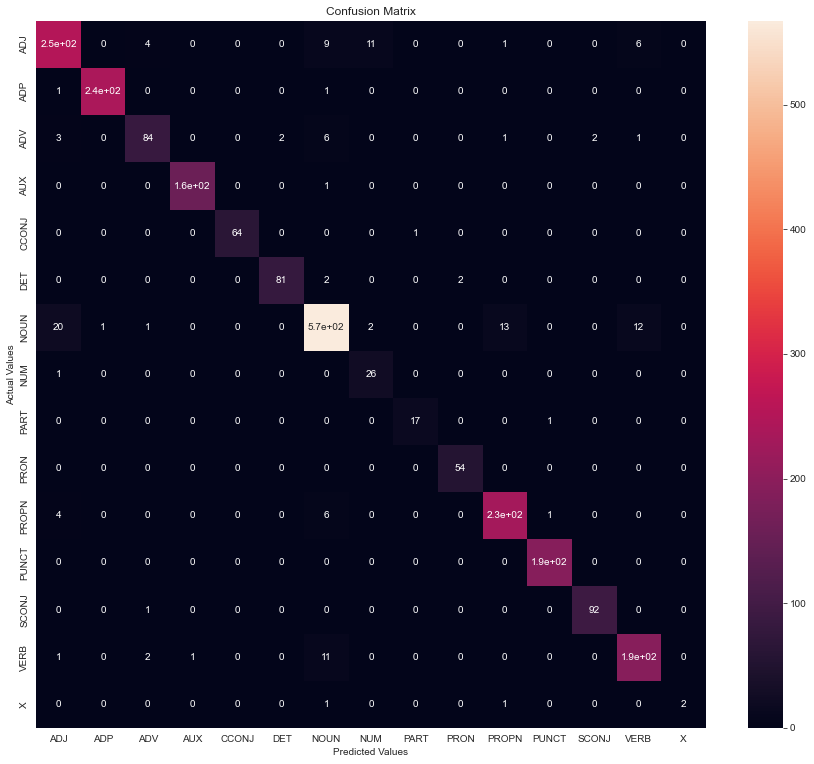

In [28]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)

# Crtanje
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig(f"resources/model_library/custom_upos_tagger/confusion_matrix.png")
plt.show()

In [29]:
print(metrics.classification_report(actual,predicted))

              precision    recall  f1-score   support

         ADJ       0.89      0.89      0.89       282
         ADP       1.00      0.99      0.99       243
         ADV       0.91      0.85      0.88        99
         AUX       0.99      0.99      0.99       158
       CCONJ       1.00      0.98      0.99        65
         DET       0.98      0.95      0.96        85
        NOUN       0.94      0.92      0.93       616
         NUM       0.67      0.96      0.79        27
        PART       0.94      0.94      0.94        18
        PRON       0.96      1.00      0.98        54
       PROPN       0.94      0.95      0.95       243
       PUNCT       0.99      1.00      0.99       191
       SCONJ       0.98      0.99      0.98        93
        VERB       0.91      0.93      0.92       209
           X       1.00      0.50      0.67         4

    accuracy                           0.94      2387
   macro avg       0.94      0.92      0.92      2387
weighted avg       0.95   

In [30]:
def serialize_int32(obj):
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError ("Type %s is not serializable" % type(obj))

In [31]:
# Cuvanje rezultata
with open(f"resources/model_library/custom_upos_tagger/best_params.json", "w") as f:
     f.write(json.dumps(best_params, default=serialize_int32))

In [32]:
with open(f"resources/model_library/custom_upos_tagger/model_hist.json", "w") as f:
    f.write(json.dumps(model_history,default=serialize_int32))

In [34]:
sentence = corpus2.test[17]
model.predict(sentence)
print("\n\n")

# Predvidi etikete i štampaj
for i,token in enumerate(sentence):
    predictedLabels = token.get_labels('upos')
    actualLabels = sentence[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




Ključni - predicted: ADJ , actual: ADJ
dogovori - predicted: ADJ , actual: ADJ
postignuti - predicted: NOUN , actual: NOUN
tokom - predicted: ADP , actual: ADP
dvodnevnog - predicted: ADJ , actual: ADJ
samita - predicted: NOUN , actual: NOUN
NATO-a - predicted: PROPN , actual: PROPN
u - predicted: ADP , actual: ADP
Istanbulu - predicted: PROPN , actual: PROPN
uključuju - predicted: VERB , actual: VERB
i - predicted: CCONJ , actual: CCONJ
odluku - predicted: NOUN , actual: NOUN
o - predicted: ADP , actual: ADP
pokretanju - predicted: NOUN , actual: NOUN
programa - predicted: NOUN , actual: NOUN
obuke - predicted: NOUN , actual: NOUN
iračkih - predicted: ADJ , actual: ADJ
snaga - predicted: NOUN , actual: NOUN
bezbednosti - predicted: NOUN , actual: NOUN
i - predicted: CCONJ , actual: CCONJ
obećanje - predicted: NOUN , actual: NOUN
da - predicted: SCONJ , actual: SCONJ
će - predicted: AUX , actual: AUX
biti - predicted: AUX , actual: AUX
povećan - predicted: ADJ , actual: ADJ
broj - p